In [68]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings


In [69]:


# Ignore SettingWithCopyWarning
warnings.filterwarnings('ignore')

df_2 = pd.read_csv("../resources/lego.population.csv", sep =",", encoding ="latin1")

#Kiutter ut kolonner fra datasettet vi ikke trenger
df2 = df_2[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Unique_Pieces', 'Minifigures']]

# Gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# Fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

#egen rens
df2['Gender'] = "Neutral"

#legger til boy names
boy_names = []

with open("../resources/boy_names.txt") as file:
  for index, line in enumerate(file):
    if index < 6:
      continue
    name = line.strip().lower()

    boy_names.append(name)

#legger til girl names
girl_names = []

with open("../resources/girl_names.txt") as file:
  for index, line in enumerate(file):
    if index < 6:
      continue
    name = line.strip().lower()

    girl_names.append(name)

#funksjon som sjekker om et navn finnes i listen over jenter
def inGirlList(set_name):
  for girl in girl_names:
    if str(set_name).find(girl) != -1:
      return "Girl"
  return "Neutral"

#funksjon som sjekker om et navn finnes i listen over gutter
def inBoyList(set_name):
  for boy in boy_names:
    if str(set_name).find(boy) != -1:
      return "Boy"
  return "Neutral"

#kategoriserer hvert stt etter om set_navnet finnes i jente- eller guttelistene.
df2['Gender'] = df2['Set_Name'].apply(lambda x: inGirlList(x) if inGirlList(x) == 1 else inBoyList(x))


#Legger til en rekke kobliner mellom tema og kjønn
themes = dict()
for line in open("../resources/theme_gender.txt"):
  if line.startswith("*") or line.isspace():
    continue
  else:
    words = line.strip().split("=")
    themes[words[0].lower().replace(" ", "")] = words[1].replace(" ", "")

#setter nye gender-verdier for sett som har en theme
for index, lego_set in df_2.iterrows():
  set_theme = str(lego_set["Theme"]).lower().replace(" ", "")
  if set_theme in themes.keys():
    newValue = int((themes[set_theme]))

    if newValue == 1:
      df2['Gender'][index] = "Boy"


    elif newValue == 2:
      df2['Gender'][index] = "Girl"
    else:
      df2['Gender'][index] = "Neutral"

df2['Gender'] = pd.Categorical(df2['Gender'])

#dropper lego_sett som har NaN-verdier i en av kolonnene
df2 = df2.dropna()

df2

,Set_Name,Theme,Pieces,Price,Pages,Unique_Pieces,Minifigures,Gender
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,52.0,1.0,Girl
16,Woody & RC,Disney,69.0,9.99,28.0,36.0,1.0,Neutral
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,41.0,1.0,Girl
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,48.0,2.0,Girl
19,Police Patrol Car,City,92.0,9.99,36.0,52.0,1.0,Neutral
...,...,...,...,...,...,...,...,...
1171,1989 Batmobile,Batman,3306.0,249.99,404.0,484.0,3.0,Neutral
1172,Tree House,Ideas,3036.0,199.99,428.0,482.0,4.0,Neutral
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,692.0,13.0,Boy
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,525.0,6.0,Boy


In [70]:
#multippel lineær modell
modell_mlr = smf.ols('Price ~ Pages + Pieces * C(Gender, Treatment("Girl"))', data = df2)
print(modell_mlr.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     712.3
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          1.31e-304
Time:                        18:14:18   Log-Likelihood:                -3328.0
No. Observations:                 752   AIC:                             6670.
Df Residuals:                     745   BIC:                             6702.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

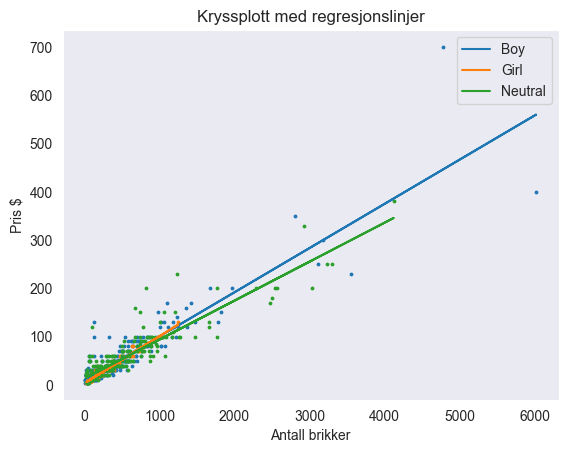

In [71]:
myGenders = ['Boy', 'Girl', 'Neutral']
subset_df = df2[df2['Gender'].isin(myGenders)]

#Enkel lineær regresjon for hvert kjønn hver for seg
resultater = []
for i, gender in enumerate(myGenders):
  sub_model_gender = smf.ols('Price ~ Pieces', data=subset_df[subset_df['Gender'] == gender])
  resultater.append(sub_model_gender.fit())

# plott av dataene og regresjonslinjene
for i, gender in enumerate(myGenders):
  slope = resultater[i].params['Pieces']
  intercept = resultater[i].params['Intercept']

  regression_x = np.array(subset_df[subset_df['Gender'] == gender]['Pieces'])
  regression_y = slope * regression_x + intercept

  # Plot scatter plot and regression line
  plt.scatter(subset_df[subset_df['Gender'] == gender]['Pieces'], subset_df[subset_df['Gender'] == gender]['Price'], color=plt.cm.tab10(i), s=3)
  plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=gender)

plt.xlabel('Antall brikker')
plt.ylabel('Pris $')


plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()


plt.show()


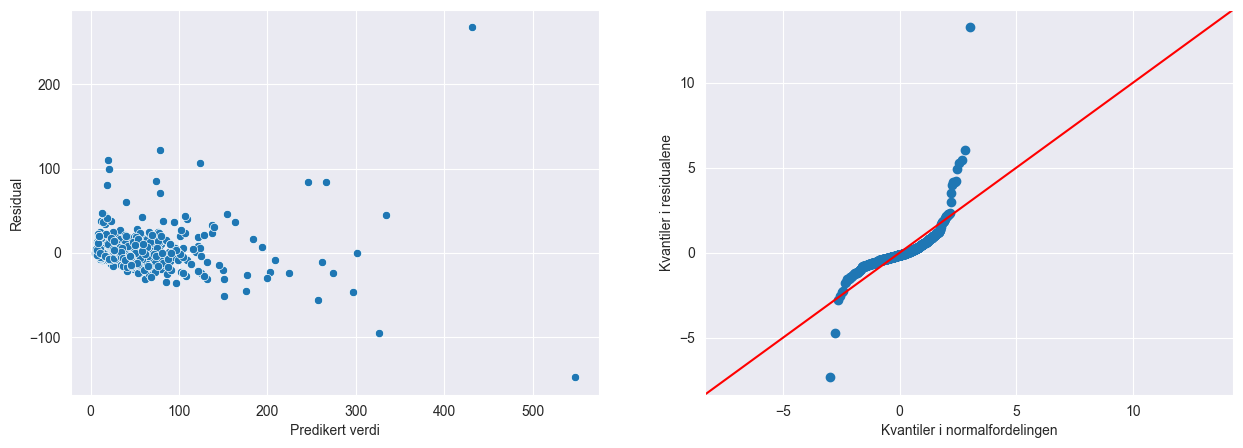

In [72]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell_mlr.fit().fittedvalues, y = modell_mlr.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell_mlr.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

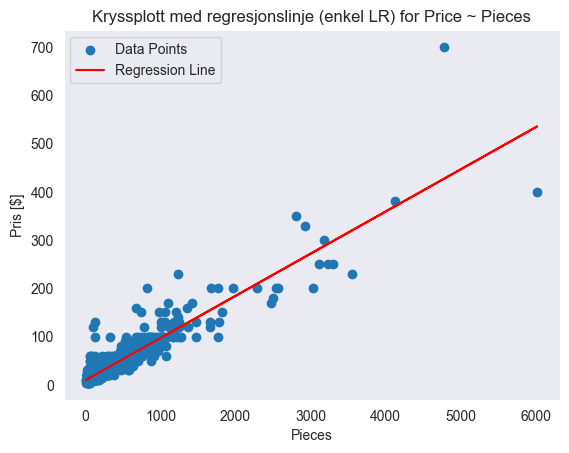

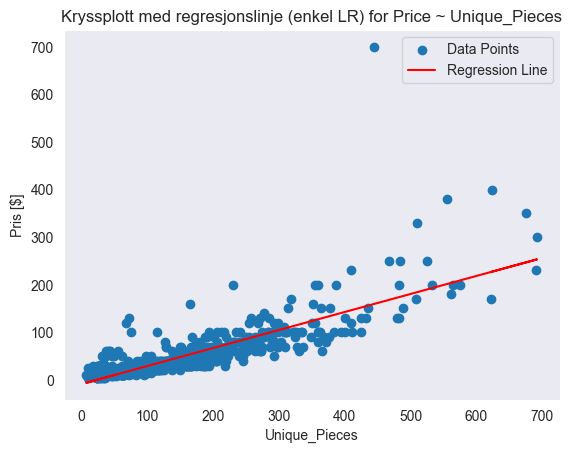

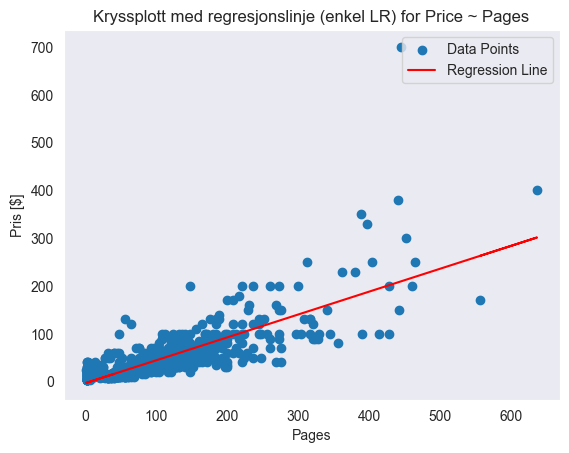

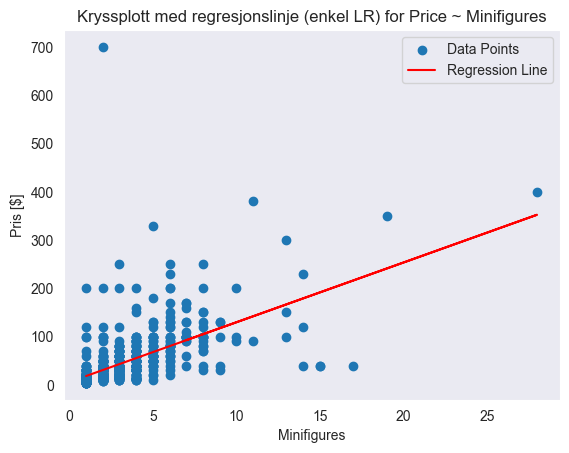

In [73]:
#Enkel lineær regresjon av alle de forskjellige variablene mot pris

variables = ['Pieces', 'Unique_Pieces', 'Pages', 'Minifigures']


for i in variables:
  formel = 'Price ~ ' + str(i)

  modell = smf.ols(formel, data = df2)
  resultat = modell.fit()

  resultat.summary()

  slope = resultat.params[i]
  intercept = resultat.params['Intercept']

  regression_x = np.array(df2[i])

  regression_y = slope * regression_x + intercept

  plt.scatter(df2[i], df2['Price'], label='Data Points')
  plt.plot(regression_x, regression_y, color='red', label='Regression Line')
  plt.xlabel(i)
  plt.ylabel('Pris [$]')
  plt.title('Kryssplott med regresjonslinje (enkel LR) for ' + formel)
  plt.legend()
  plt.grid()
  plt.show()

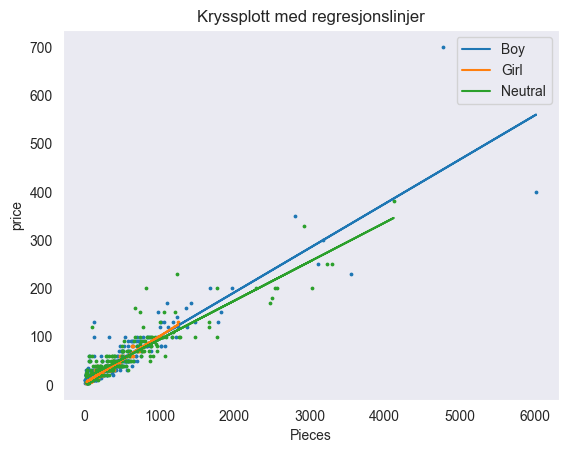

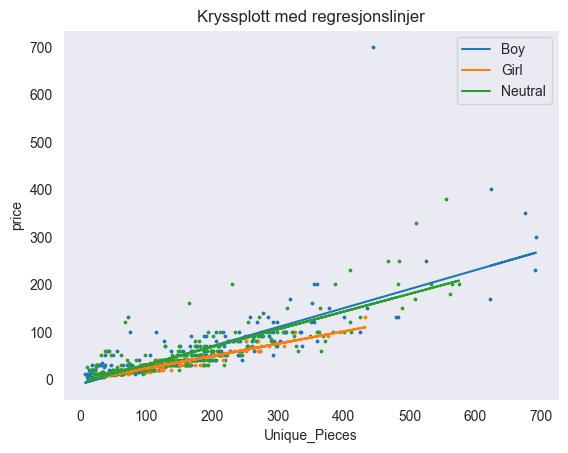

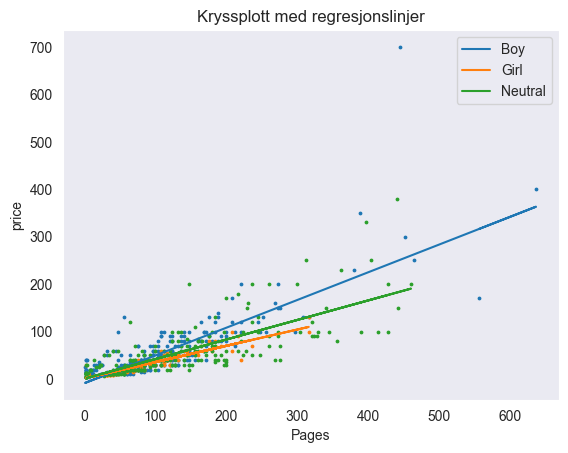

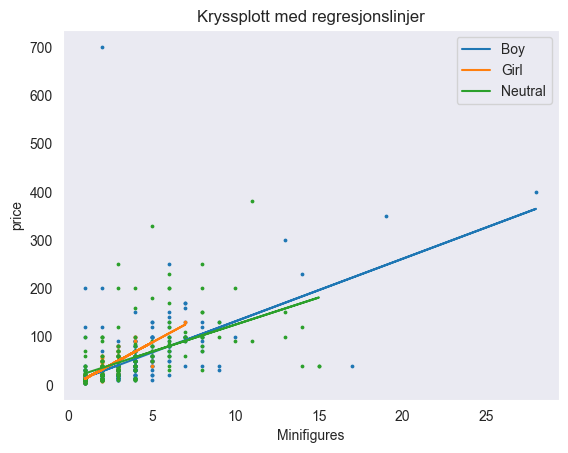

In [74]:

#Lineær regresjon for de forskjellige forklaringsvariablene, med en regresjonslinje for hvert kjønn
for type in ['Pieces', 'Unique_Pieces', 'Pages', 'Minifigures']:
  myGenders = ['Boy', 'Girl', 'Neutral']
  subset_df = df2[df2['Gender'].isin(myGenders)]

  resultater = []
  for i, gender in enumerate(myGenders):
    sub_model_gender = smf.ols('Price ~ ' + type, data=subset_df[subset_df['Gender'] == gender])
    resultater.append(sub_model_gender.fit())

  # plott av dataene og regresjonslinjene
  for i, gender in enumerate(myGenders):
    slope = resultater[i].params[type]
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['Gender'] == gender][type])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Gender'] == gender][type], subset_df[subset_df['Gender'] == gender]['Price'], color=plt.cm.tab10(i), s=3)
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=gender)

  plt.xlabel(type)
  plt.ylabel("price")


  plt.title('Kryssplott med regresjonslinjer')
  plt.legend()
  plt.grid()


  plt.show()